# Experiment 1 & 2

- Rank metrics for each model for each product category. The metrics are the average over all folds. (total of 32 weeks)
- Plots over time
- Statistical tests to compare predictions from experiment 1 with experiment 2 

In [1]:
import itertools
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_squared_error, r2_score
import yaml
from tqdm import tqdm 
import mlflow
from glob import glob

# Get the current project path (where you open the notebook)
# and go up two levels to get the project path
current_dir = Path.cwd()
proj_path = current_dir.parent.parent

# make the code in src available to import in this notebook
import sys
sys.path.append(os.path.join(proj_path,'src'))

import xgboost as xgb
from xgboost import XGBClassifier

from metrics import *
from utils import *

# Catalog contains all the paths related to datasets
with open(os.path.join(proj_path, 'conf/catalog.yml'), "r") as f:
    catalog = yaml.safe_load(f)['olist']
    
# Params contains all of the dataset creation parameters and model parameters
with open(os.path.join(proj_path, 'conf/params.yml'), "r") as f:
    params = yaml.safe_load(f)

In [2]:
prod_categories = params['olist']['product_categories']
date_ranges = make_dates(params['olist']['experiment_dates'])

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
# Aggregate all predictions of each model for exp1

all_product_categories = {}
base_mae_rmse_ll = []

for prod_cat in prod_categories:
    xgb_exp1 = pd.read_csv(proj_path / catalog['results']['dir'] / f'xgb_exp1_{prod_cat}.csv')
    xgb_exp2 =pd.read_csv(proj_path / catalog['results']['dir'] / f'xgb_exp2_{prod_cat}.csv')
    lstm_exp1 =pd.read_csv(proj_path / catalog['results']['dir'] / f'lstm_exp1_{prod_cat}.csv')
    lstm_exp2 =pd.read_csv(proj_path / catalog['results']['dir'] / f'lstm_exp2_{prod_cat}.csv')

    # clean up each experiments and standardize their outputs here
    xgb_exp1 = xgb_exp1.rename(columns={'preds': 'y_pred_xgb'})
    xgb_exp2 = xgb_exp2.rename(columns={'preds': 'y_pred_xgb_gtrend'})
    lstm_exp1 = lstm_exp1.rename(columns={'y_pred': 'y_pred_lstm'}) # can be lt_preds
    lstm_exp2 = lstm_exp2.rename(columns={'y_pred': 'y_pred_lstm_gtrend'})

    # Sets the index the same for all dfs so they can be concatenated based on the index
    xgb_exp1.set_index('dates', inplace=True)
    xgb_exp2.set_index('dates', inplace=True)
    lstm_exp1.set_index('dates', inplace=True)
    lstm_exp2.set_index('dates', inplace=True)

    base_metrics = pd.read_csv(proj_path / catalog['results']['dir'] / f'naive_training_{prod_cat}.csv')
    
    df = pd.concat([xgb_exp1[['y_true','y_pred_xgb']],
                    xgb_exp2['y_pred_xgb_gtrend'],
                    lstm_exp1['y_pred_lstm'],
                    lstm_exp2['y_pred_lstm_gtrend']], axis=1)
    
    all_product_categories[prod_cat] = df

    base_mae_rmse_ll.append({'product_category': prod_cat,
                             'base_mae':base_metrics['train_mae'].values[0],
                             'base_rmse':base_metrics['train_rmse'].values[0]})
    
base_mae_rmse = pd.DataFrame(base_mae_rmse_ll)

In [4]:
def get_min_max(df, date_ranges):
    
    _metrics_xgb = []
    _metrics_xgb_gtrends = []
    _metrics_lstm = []
    _metrics_lstm_gtrends = []
    
    for window in date_ranges.itertuples():
        # Filter period
        temp = df[(pd.to_datetime(df.index) >= window[5]) & 
                  (pd.to_datetime(df.index) <= window[6])]
        _metrics_xgb.append(get_metrics(temp['y_true'],temp['y_pred_xgb']))
        _metrics_xgb_gtrends.append(get_metrics(temp['y_true'],temp['y_pred_xgb_gtrend']))
        _metrics_lstm.append(get_metrics(temp['y_true'],temp['y_pred_lstm']))
        _metrics_lstm_gtrends.append(get_metrics(temp['y_true'],temp['y_pred_lstm_gtrend']))
    
    # Get the min and max for each metric for each model
    return pd.DataFrame({'model':['xgb','xgb_gtrend','lstm','lstm_gtrend'],
                      'min_wape':[pd.DataFrame(_metrics_xgb)['wape'].min(),
                                 pd.DataFrame(_metrics_xgb_gtrends)['wape'].min(),
                                 pd.DataFrame(_metrics_lstm)['wape'].min(),
                                 pd.DataFrame(_metrics_lstm_gtrends)['wape'].min()],
                      'min_rmse':[pd.DataFrame(_metrics_xgb)['rmse'].min(),
                                 pd.DataFrame(_metrics_xgb_gtrends)['rmse'].min(),
                                 pd.DataFrame(_metrics_lstm)['rmse'].min(),
                                 pd.DataFrame(_metrics_lstm_gtrends)['rmse'].min()],
                      'min_r2':[pd.DataFrame(_metrics_xgb)['r2'].min(),
                                 pd.DataFrame(_metrics_xgb_gtrends)['r2'].min(),
                                 pd.DataFrame(_metrics_lstm)['r2'].min(),
                                 pd.DataFrame(_metrics_lstm_gtrends)['r2'].min()],
                     'min_mape':[pd.DataFrame(_metrics_xgb)['mape'].min(),
                                 pd.DataFrame(_metrics_xgb_gtrends)['mape'].min(),
                                 pd.DataFrame(_metrics_lstm)['mape'].min(),
                                 pd.DataFrame(_metrics_lstm_gtrends)['mape'].min()],
                     'max_wape':[pd.DataFrame(_metrics_xgb)['wape'].max(),
                                 pd.DataFrame(_metrics_xgb_gtrends)['wape'].max(),
                                 pd.DataFrame(_metrics_lstm)['wape'].max(),
                                 pd.DataFrame(_metrics_lstm_gtrends)['wape'].max()],
                      'max_rmse':[pd.DataFrame(_metrics_xgb)['rmse'].max(),
                                 pd.DataFrame(_metrics_xgb_gtrends)['rmse'].max(),
                                 pd.DataFrame(_metrics_lstm)['rmse'].max(),
                                 pd.DataFrame(_metrics_lstm_gtrends)['rmse'].max()],
                      'max_r2':[pd.DataFrame(_metrics_xgb)['r2'].max(),
                                 pd.DataFrame(_metrics_xgb_gtrends)['r2'].max(),
                                 pd.DataFrame(_metrics_lstm)['r2'].max(),
                                 pd.DataFrame(_metrics_lstm_gtrends)['r2'].max()],
                     'max_mape':[pd.DataFrame(_metrics_xgb)['mape'].max(),
                                 pd.DataFrame(_metrics_xgb_gtrends)['mape'].max(),
                                 pd.DataFrame(_metrics_lstm)['mape'].max(),
                                 pd.DataFrame(_metrics_lstm_gtrends)['mape'].max()],
                     'max_mae':[pd.DataFrame(_metrics_xgb)['mae'].max(),
                                 pd.DataFrame(_metrics_xgb_gtrends)['mae'].max(),
                                 pd.DataFrame(_metrics_lstm)['mae'].max(),
                                 pd.DataFrame(_metrics_lstm_gtrends)['mae'].max()],
                     'min_mae':[pd.DataFrame(_metrics_xgb)['mae'].min(),
                                 pd.DataFrame(_metrics_xgb_gtrends)['mae'].min(),
                                 pd.DataFrame(_metrics_lstm)['mae'].min(),
                                 pd.DataFrame(_metrics_lstm_gtrends)['mae'].min()]})
    

In [5]:
# metrics_df_xgb = pd.DataFrame()
metrics_df = pd.DataFrame()
metrics_mase_rmsse = pd.DataFrame()

for model in ['xgb', 'lstm']:
    for prod_cat in prod_categories:

        temp = all_product_categories[prod_cat]

        # Get metrics for each model
        metrics_xgb = get_metrics(temp['y_true'],temp[f'y_pred_{model}'])
        metrics_xgb_gtrends = get_metrics(temp['y_true'],temp[f'y_pred_{model}_gtrend'])
        metrics_lstm = get_metrics(temp['y_true'],temp['y_pred_lstm'])
        metrics_lstm_gtrends = get_metrics(temp['y_true'],temp['y_pred_lstm_gtrend'])

        results = pd.DataFrame([metrics_xgb,
                                metrics_xgb_gtrends,
                                metrics_lstm,
                                metrics_lstm_gtrends], 
                           index=['xgb','xgb_gtrend','lstm','lstm_gtrend'])
        
        results['product_category'] = prod_cat

        results = results.reset_index().rename(columns={'index':'model'})

        # Calculate the ranks for each metric
        results['rank_mape'] = results.rank(axis=0)['mape']
        results['rank_wape'] = results.rank(axis=0)['wape']
        results['rank_rmse'] = results.rank(axis=0)['rmse']
        results['rank_r2'] = results.rank(axis=0, ascending=False)['r2']
        
        # Add rank for rmsse and mase
        results = results.merge(base_mae_rmse, how='left', on='product_category')
        results['mase'] = results['mae'] / results['base_mae']
        results['rmsse'] = results['rmse'] / results['base_rmse']
        results['rank_rmsse'] = results.rank(axis=0)['rmsse']
        results['rank_mase'] = results.rank(axis=0)['mase']
    
        min_max_df = get_min_max(df, make_dates(params['olist']['experiment_dates']))
        results = results.merge(min_max_df, how='inner',on='model')  

        # Calculate the minimum and maximum of each fold.

        metrics_df = metrics_df.append(results).reset_index(drop=True)

In [6]:
metrics_df[['model', 'product_category', 'mase', 'rmsse', 'rank_mase','rank_rmsse']]

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,model,product_category,mase,rmsse,rank_mase,rank_rmsse
0,xgb,bed_bath_table,1.088770,0.936339,1.0,1.0
1,xgb_gtrend,bed_bath_table,1.856669,1.499691,4.0,4.0
2,lstm,bed_bath_table,1.375774,1.127358,2.0,2.0
3,lstm_gtrend,bed_bath_table,1.452422,1.168252,3.0,3.0
4,xgb,health_beauty,2.325275,1.787045,1.0,1.0
5,xgb_gtrend,health_beauty,2.775413,2.094761,3.0,3.0
6,lstm,health_beauty,2.755215,1.980740,2.0,2.0
7,lstm_gtrend,health_beauty,3.014046,2.209592,4.0,4.0
8,xgb,sports_leisure,2.699598,2.233374,4.0,3.0
9,xgb_gtrend,sports_leisure,2.621753,2.338819,3.0,4.0


In [7]:
metrics_df

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,model,wape,rmse,r2,mape,mae,product_category,rank_mape,rank_wape,rank_rmse,...,min_wape,min_rmse,min_r2,min_mape,max_wape,max_rmse,max_r2,max_mape,max_mae,min_mae
0,xgb,6051.712185,48.561495,-1.139324,0.205683,37.218750,bed_bath_table,1.0,1.0,1.0,...,357.393939,18.754999,-319.289157,0.285794,4872.618280,66.236319,-0.683014,0.694746,55.750000,16.250000
1,xgb_gtrend,9633.410189,77.778733,-4.488002,0.364371,63.468750,bed_bath_table,4.0,4.0,4.0,...,405.090909,15.451537,-394.036145,0.189726,4228.529126,45.268643,0.165522,0.633690,43.750000,14.250000
2,lstm,7616.654626,58.468381,-2.101235,0.261243,47.029757,bed_bath_table,2.0,2.0,2.0,...,416.651967,12.903905,-504.388470,0.142455,4904.660176,51.202565,-0.130881,0.669672,51.151134,10.755293
3,lstm_gtrend,8036.675907,60.589254,-2.330303,0.277235,49.649894,bed_bath_table,3.0,3.0,3.0,...,470.352982,16.604199,-772.416740,0.206414,6065.938321,63.341135,-0.107079,0.841698,63.294579,15.312399
4,xgb,7030.122302,65.693179,-1.128104,0.327671,55.531250,health_beauty,1.0,1.0,1.0,...,357.393939,18.754999,-319.289157,0.285794,4872.618280,66.236319,-0.683014,0.694746,55.750000,16.250000
5,xgb_gtrend,8536.656250,77.005073,-1.924092,0.386237,66.281250,health_beauty,4.0,2.0,3.0,...,405.090909,15.451537,-394.036145,0.189726,4228.529126,45.268643,0.165522,0.633690,43.750000,14.250000
6,lstm,9316.824035,72.813561,-1.614429,0.359829,65.798873,health_beauty,2.0,3.0,2.0,...,416.651967,12.903905,-504.388470,0.142455,4904.660176,51.202565,-0.130881,0.669672,51.151134,10.755293
7,lstm_gtrend,10544.878604,81.226348,-2.253465,0.383799,71.980189,health_beauty,3.0,4.0,4.0,...,470.352982,16.604199,-772.416740,0.206414,6065.938321,63.341135,-0.107079,0.841698,63.294579,15.312399
8,xgb,5984.430573,65.592016,-2.181488,0.482095,57.437500,sports_leisure,4.0,3.0,3.0,...,357.393939,18.754999,-319.289157,0.285794,4872.618280,66.236319,-0.683014,0.694746,55.750000,16.250000
9,xgb_gtrend,6593.163982,68.688836,-2.488997,0.433925,55.781250,sports_leisure,3.0,4.0,4.0,...,405.090909,15.451537,-394.036145,0.189726,4228.529126,45.268643,0.165522,0.633690,43.750000,14.250000


In [8]:
metrics_df_xgb = pd.DataFrame()
metrics_df_lstm = pd.DataFrame()
metrics_df_xgb_mase_rmsse = pd.DataFrame()
metrics_df_lstm_mase_rmsse = pd.DataFrame()

for model in ['xgb', 'lstm']:
    for prod_cat in prod_categories:

        temp = all_product_categories[prod_cat]

        # Get metrics for each model
        metrics = get_metrics(temp['y_true'],temp[f'y_pred_{model}'])
        metrics_gtrends = get_metrics(temp['y_true'],temp[f'y_pred_{model}_gtrend'])

        results = pd.DataFrame([metrics,
                                metrics_gtrends], 
                                index=[model,f'{model}_gtrend'])
        results['product_category'] = prod_cat
        results = results.reset_index().rename(columns={'index':'model'})

        # Calculate the ranks for each metric
        results['rank_mape'] = results.rank(axis=0)['mape']
        results['rank_wape'] = results.rank(axis=0)['wape']
        results['rank_rmse'] = results.rank(axis=0)['rmse']
        results['rank_r2'] = results.rank(axis=0, ascending=False)['r2']
        
        # Add rank for rmsse and mase
        results = results.merge(base_mae_rmse, how='left', on='product_category')
        results['mase'] = results['mae'] / results['base_mae']
        results['rmsse'] = results['rmse'] / results['base_rmse']
        results['rank_rmsse'] = results.rank(axis=0)['rmsse']
        results['rank_mase'] = results.rank(axis=0)['mase']
        
        min_max_df = get_min_max(df, make_dates(params['olist']['experiment_dates']))
        # left to only include model specific
        results = results.merge(min_max_df, how='left',on='model')  

        # Calculate the minimum and maximum of each fold.
        if model == 'xgb':
            metrics_df_xgb = metrics_df_xgb.append(results).reset_index(drop=True)
            metrics_df_xgb_mase_rmsse = metrics_df_xgb_mase_rmsse.append(results).reset_index(drop=True)
        if model =='lstm':
            metrics_df_lstm = metrics_df_lstm.append(results).reset_index(drop=True)
            metrics_df_lstm_mase_rmsse = metrics_df_lstm_mase_rmsse.append(results).reset_index(drop=True)
        

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
metrics_df_xgb_mase_rmsse[['model', 'product_category', 'mase', 'rmsse', 'rank_mase','rank_rmsse']]

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,model,product_category,mase,rmsse,rank_mase,rank_rmsse
0,xgb,bed_bath_table,1.088770,0.936339,1.0,1.0
1,xgb_gtrend,bed_bath_table,1.856669,1.499691,2.0,2.0
2,xgb,health_beauty,2.325275,1.787045,1.0,1.0
3,xgb_gtrend,health_beauty,2.775413,2.094761,2.0,2.0
4,xgb,sports_leisure,2.699598,2.233374,2.0,1.0
5,xgb_gtrend,sports_leisure,2.621753,2.338819,1.0,2.0
6,xgb,furniture_decor,1.622268,1.213314,1.0,1.0
7,xgb_gtrend,furniture_decor,1.827558,1.374852,2.0,2.0
8,xgb,housewares,1.756402,1.650840,1.0,1.0
9,xgb_gtrend,housewares,2.242973,2.031750,2.0,2.0


In [10]:
metrics_df_xgb

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,model,wape,rmse,r2,mape,mae,product_category,rank_mape,rank_wape,rank_rmse,...,min_wape,min_rmse,min_r2,min_mape,max_wape,max_rmse,max_r2,max_mape,max_mae,min_mae
0,xgb,6051.712185,48.561495,-1.139324,0.205683,37.21875,bed_bath_table,1.0,1.0,1.0,...,357.393939,18.754999,-319.289157,0.285794,4872.618280,66.236319,-0.683014,0.694746,55.75,16.25
1,xgb_gtrend,9633.410189,77.778733,-4.488002,0.364371,63.46875,bed_bath_table,2.0,2.0,2.0,...,405.090909,15.451537,-394.036145,0.189726,4228.529126,45.268643,0.165522,0.633690,43.75,14.25
2,xgb,7030.122302,65.693179,-1.128104,0.327671,55.53125,health_beauty,1.0,1.0,1.0,...,357.393939,18.754999,-319.289157,0.285794,4872.618280,66.236319,-0.683014,0.694746,55.75,16.25
3,xgb_gtrend,8536.656250,77.005073,-1.924092,0.386237,66.28125,health_beauty,2.0,2.0,2.0,...,405.090909,15.451537,-394.036145,0.189726,4228.529126,45.268643,0.165522,0.633690,43.75,14.25
4,xgb,5984.430573,65.592016,-2.181488,0.482095,57.43750,sports_leisure,2.0,1.0,1.0,...,357.393939,18.754999,-319.289157,0.285794,4872.618280,66.236319,-0.683014,0.694746,55.75,16.25
5,xgb_gtrend,6593.163982,68.688836,-2.488997,0.433925,55.78125,sports_leisure,1.0,2.0,2.0,...,405.090909,15.451537,-394.036145,0.189726,4228.529126,45.268643,0.165522,0.633690,43.75,14.25
6,xgb,3968.998468,48.754166,-0.868095,0.365257,42.96875,furniture_decor,1.0,1.0,1.0,...,357.393939,18.754999,-319.289157,0.285794,4872.618280,66.236319,-0.683014,0.694746,55.75,16.25
7,xgb_gtrend,4283.959559,55.245192,-1.398637,0.417243,48.40625,furniture_decor,2.0,2.0,2.0,...,405.090909,15.451537,-394.036145,0.189726,4228.529126,45.268643,0.165522,0.633690,43.75,14.25
8,xgb,4047.135554,47.738218,-0.359963,0.271704,37.00000,housewares,1.0,1.0,1.0,...,357.393939,18.754999,-319.289157,0.285794,4872.618280,66.236319,-0.683014,0.694746,55.75,16.25
9,xgb_gtrend,4845.380620,58.753191,-1.059955,0.358224,47.25000,housewares,2.0,2.0,2.0,...,405.090909,15.451537,-394.036145,0.189726,4228.529126,45.268643,0.165522,0.633690,43.75,14.25


In [11]:
metrics_df_lstm_mase_rmsse[['model', 'product_category', 'mase', 'rmsse', 'rank_mase','rank_rmsse']]

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,model,product_category,mase,rmsse,rank_mase,rank_rmsse
0,lstm,bed_bath_table,1.375774,1.127358,1.0,1.0
1,lstm_gtrend,bed_bath_table,1.452422,1.168252,2.0,2.0
2,lstm,health_beauty,2.755215,1.980740,1.0,1.0
3,lstm_gtrend,health_beauty,3.014046,2.209592,2.0,2.0
4,lstm,sports_leisure,2.059830,1.803583,2.0,2.0
5,lstm_gtrend,sports_leisure,2.000143,1.735897,1.0,1.0
6,lstm,furniture_decor,1.542609,1.192113,2.0,2.0
7,lstm_gtrend,furniture_decor,1.476848,1.147131,1.0,1.0
8,lstm,housewares,2.247420,1.968756,1.0,1.0
9,lstm_gtrend,housewares,2.260655,2.028027,2.0,2.0


In [12]:
metrics_df_lstm

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,model,wape,rmse,r2,mape,mae,product_category,rank_mape,rank_wape,rank_rmse,...,min_wape,min_rmse,min_r2,min_mape,max_wape,max_rmse,max_r2,max_mape,max_mae,min_mae
0,lstm,7616.654626,58.468381,-2.101235,0.261243,47.029757,bed_bath_table,1.0,1.0,1.0,...,416.651967,12.903905,-504.38847,0.142455,4904.660176,51.202565,-0.130881,0.669672,51.151134,10.755293
1,lstm_gtrend,8036.675907,60.589254,-2.330303,0.277235,49.649894,bed_bath_table,2.0,2.0,2.0,...,470.352982,16.604199,-772.41674,0.206414,6065.938321,63.341135,-0.107079,0.841698,63.294579,15.312399
2,lstm,9316.824035,72.813561,-1.614429,0.359829,65.798873,health_beauty,1.0,1.0,1.0,...,416.651967,12.903905,-504.38847,0.142455,4904.660176,51.202565,-0.130881,0.669672,51.151134,10.755293
3,lstm_gtrend,10544.878604,81.226348,-2.253465,0.383799,71.980189,health_beauty,2.0,2.0,2.0,...,470.352982,16.604199,-772.41674,0.206414,6065.938321,63.341135,-0.107079,0.841698,63.294579,15.312399
4,lstm,5666.714400,52.969484,-1.074817,0.317346,43.825600,sports_leisure,2.0,2.0,2.0,...,416.651967,12.903905,-504.38847,0.142455,4904.660176,51.202565,-0.130881,0.669672,51.151134,10.755293
5,lstm_gtrend,5385.241036,50.981602,-0.922008,0.312641,42.555682,sports_leisure,1.0,1.0,1.0,...,470.352982,16.604199,-772.41674,0.206414,6065.938321,63.341135,-0.107079,0.841698,63.294579,15.312399
6,lstm,4198.771209,47.902247,-0.803380,0.337594,40.858852,furniture_decor,2.0,2.0,2.0,...,416.651967,12.903905,-504.38847,0.142455,4904.660176,51.202565,-0.130881,0.669672,51.151134,10.755293
7,lstm_gtrend,4024.791707,46.094735,-0.669853,0.329082,39.117027,furniture_decor,1.0,1.0,1.0,...,470.352982,16.604199,-772.41674,0.206414,6065.938321,63.341135,-0.107079,0.841698,63.294579,15.312399
8,lstm,5038.367867,56.931553,-0.934198,0.348501,47.343686,housewares,2.0,1.0,1.0,...,416.651967,12.903905,-504.38847,0.142455,4904.660176,51.202565,-0.130881,0.669672,51.151134,10.755293
9,lstm_gtrend,5211.720999,58.645538,-1.052413,0.344438,47.622493,housewares,1.0,2.0,2.0,...,470.352982,16.604199,-772.41674,0.206414,6065.938321,63.341135,-0.107079,0.841698,63.294579,15.312399


In [13]:
all_dfs_xgb = []
all_dfs_lstm = []

for metric in ['mape','rmse','wape','r2','mase','rmsse']:
    # Do this for xgb
    rank_df = pd.DataFrame(metrics_df_xgb.groupby('model')[f'rank_{metric}'].value_counts().rename(f'cnt_rank_{metric}')).reset_index()
    rank_df[f'rank_{metric}'] = rank_df[f'rank_{metric}'].astype(int)
    all_dfs_xgb.append(rank_df.pivot_table(index='model', columns=f'rank_{metric}', values=f'cnt_rank_{metric}').add_prefix(f'{metric}_'))
    
    # Do this for lstm
    rank_df = pd.DataFrame(metrics_df_lstm.groupby('model')[f'rank_{metric}'].value_counts().rename(f'cnt_rank_{metric}')).reset_index()
    rank_df[f'rank_{metric}'] = rank_df[f'rank_{metric}'].astype(int)
    all_dfs_lstm.append(rank_df.pivot_table(index='model', columns=f'rank_{metric}', values=f'cnt_rank_{metric}').add_prefix(f'{metric}_'))
    

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
pd.concat(all_dfs_xgb,axis=1)

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,mape_1,mape_2,rmse_1,rmse_2,wape_1,wape_2,r2_1,r2_2,mase_1,mase_2,rmsse_1,rmsse_2
model,,,,,,,,,,,,
xgb,5,2,6,1,6,1,6,1,5,2,6,1
xgb_gtrend,2,5,1,6,1,6,1,6,2,5,1,6


In [15]:
pd.concat(all_dfs_lstm,axis=1)

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,mape_1,mape_2,rmse_1,rmse_2,wape_1,wape_2,r2_1,r2_2,mase_1,mase_2,rmsse_1,rmsse_2
model,,,,,,,,,,,,
lstm,4,3,5,2,5,2,5,2,5,2,5,2
lstm_gtrend,3,4,2,5,2,5,2,5,2,5,2,5


In [16]:
# View individual ranks for each metrics per model
# You can switch all_dfs_xgb for all_dfs_lstm
for df_metric in all_dfs_xgb: # all_dfs_lstm
    display(df_metric)

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


rank_mape,mape_1,mape_2
model,,
xgb,5,2
xgb_gtrend,2,5


rank_rmse,rmse_1,rmse_2
model,,
xgb,6,1
xgb_gtrend,1,6


rank_wape,wape_1,wape_2
model,,
xgb,6,1
xgb_gtrend,1,6


rank_r2,r2_1,r2_2
model,,
xgb,6,1
xgb_gtrend,1,6


rank_mase,mase_1,mase_2
model,,
xgb,5,2
xgb_gtrend,2,5


rank_rmsse,rmsse_1,rmsse_2
model,,
xgb,6,1
xgb_gtrend,1,6


C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


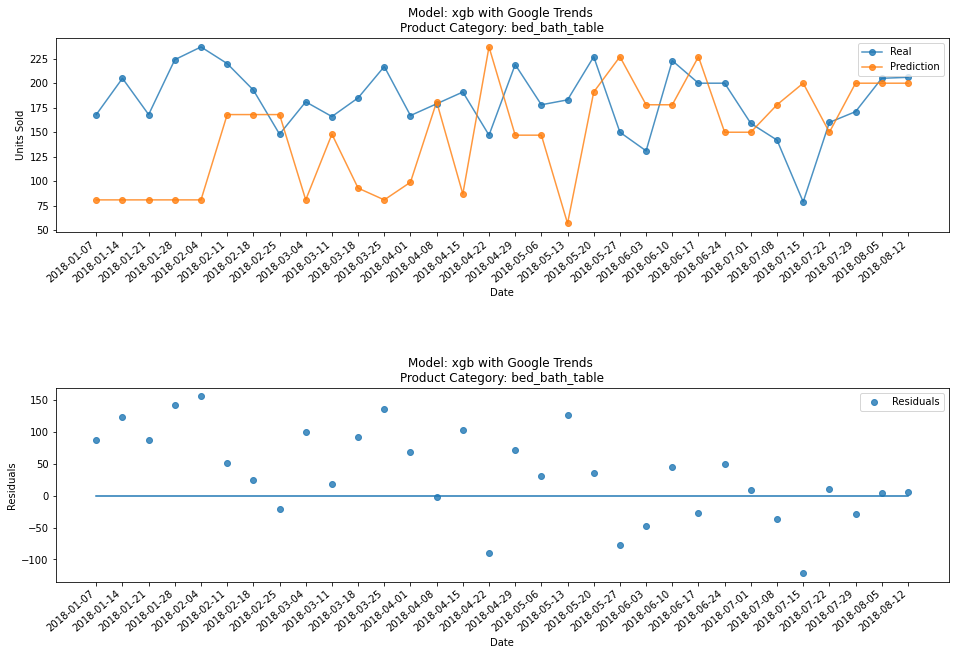

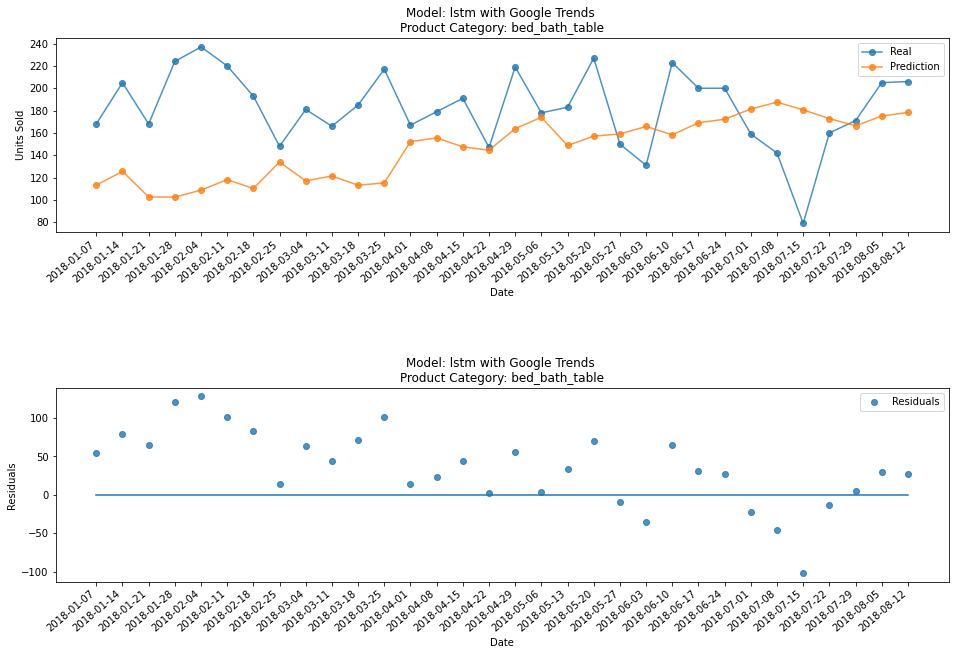

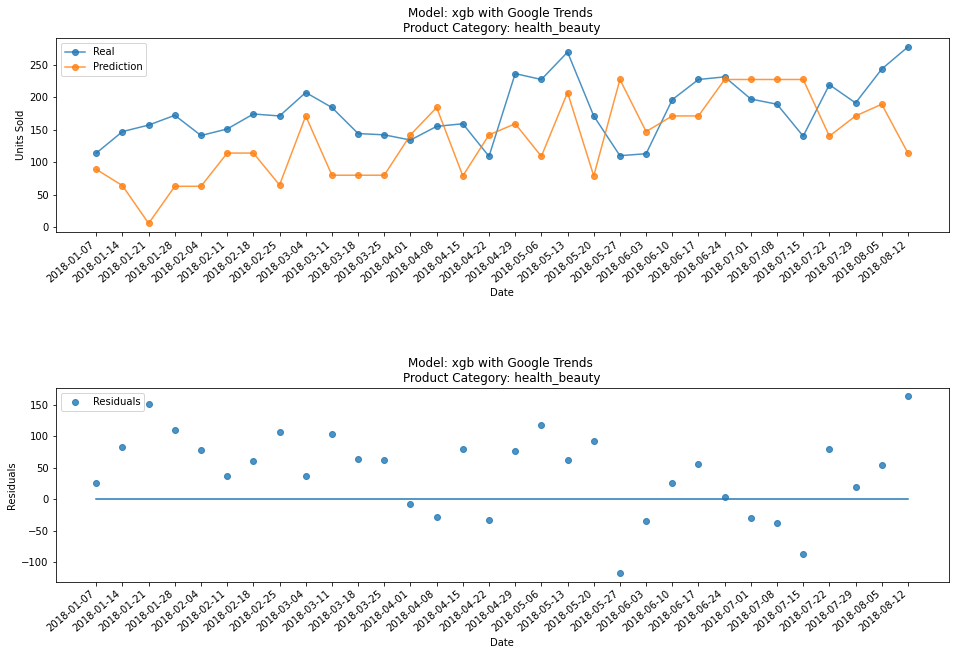

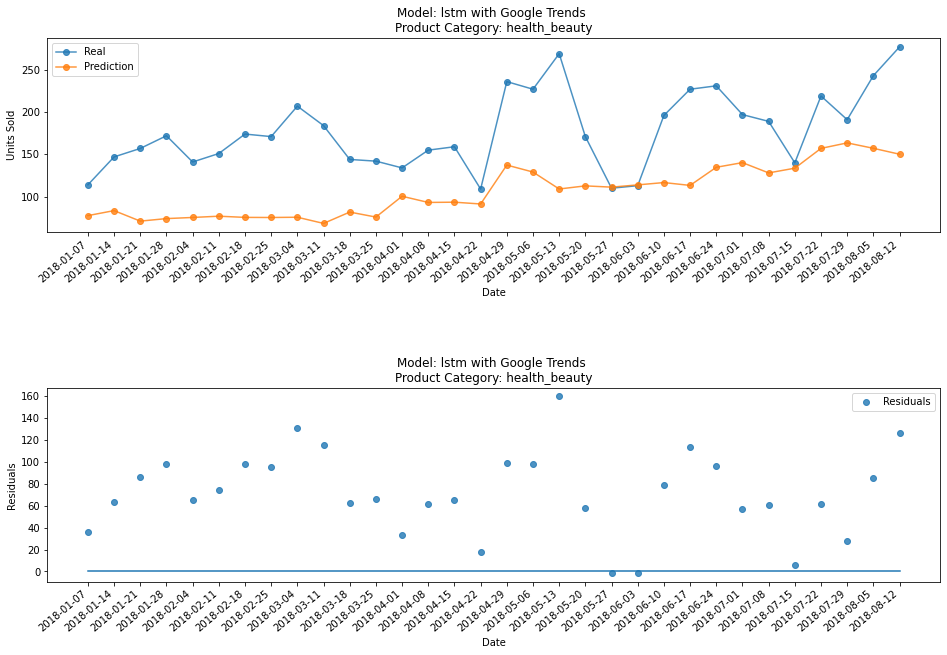

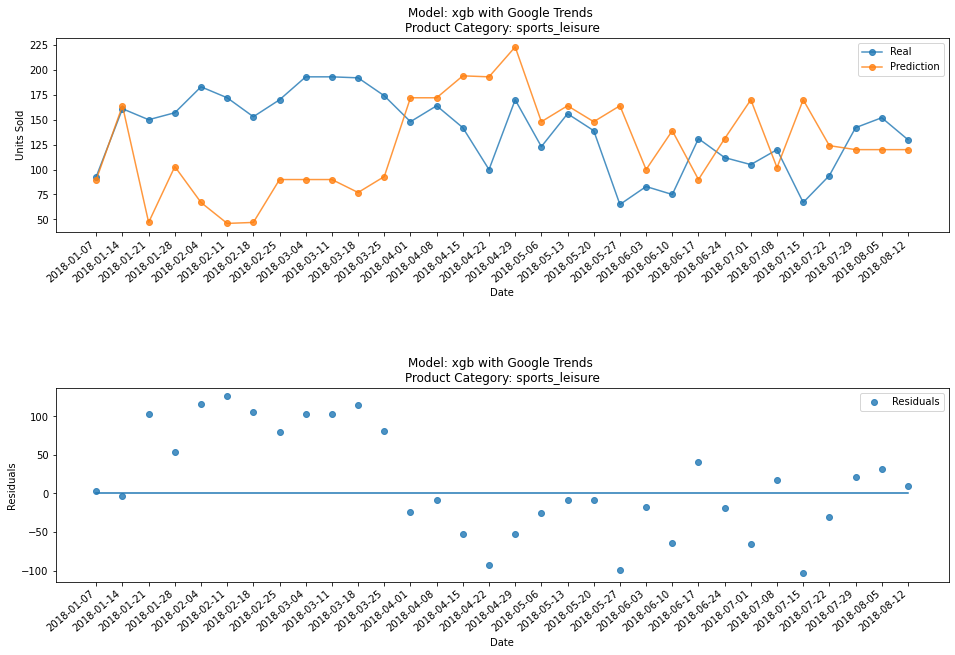

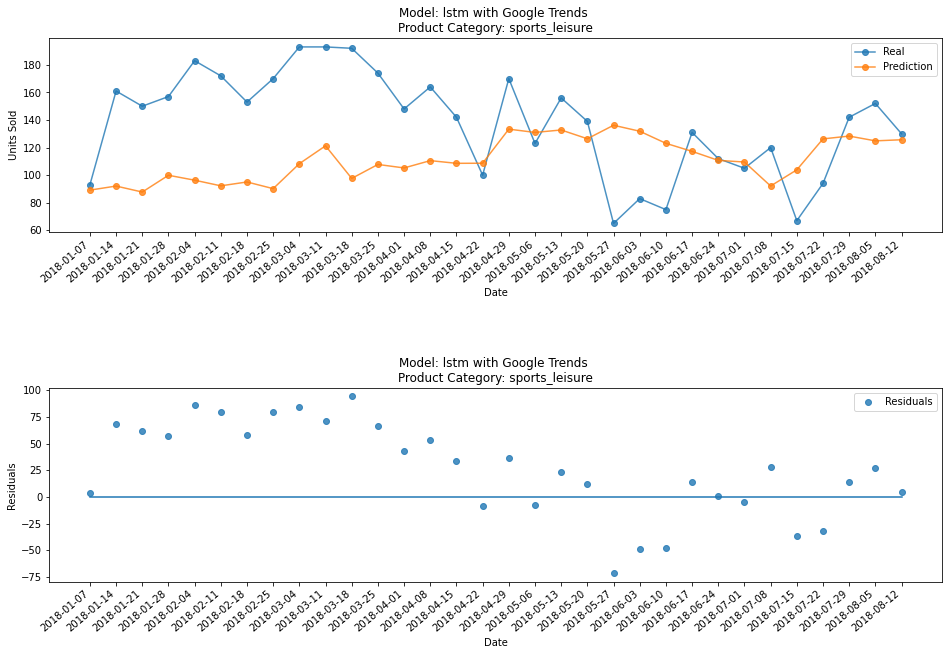

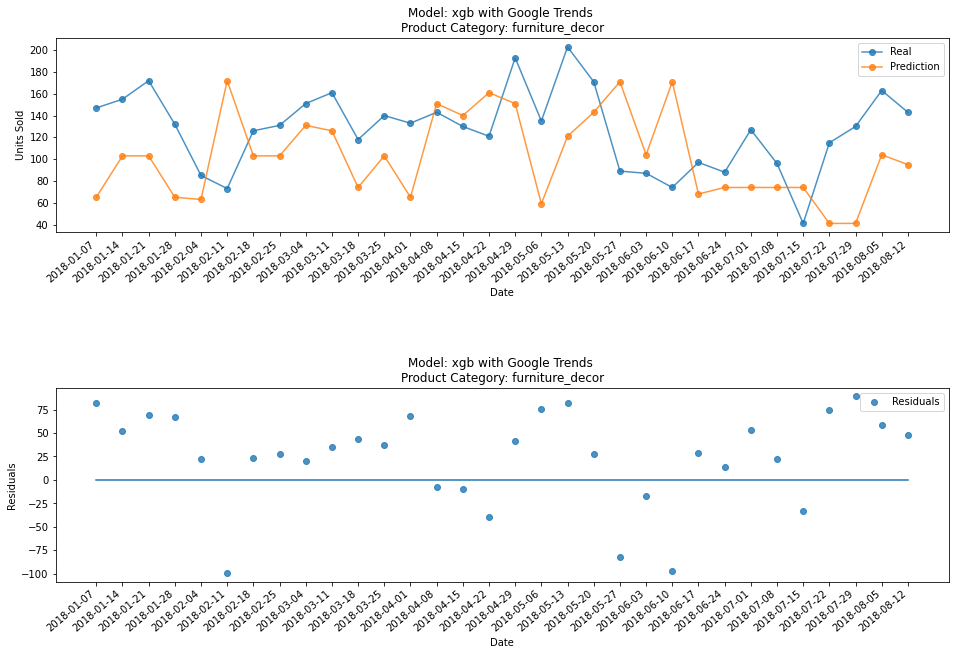

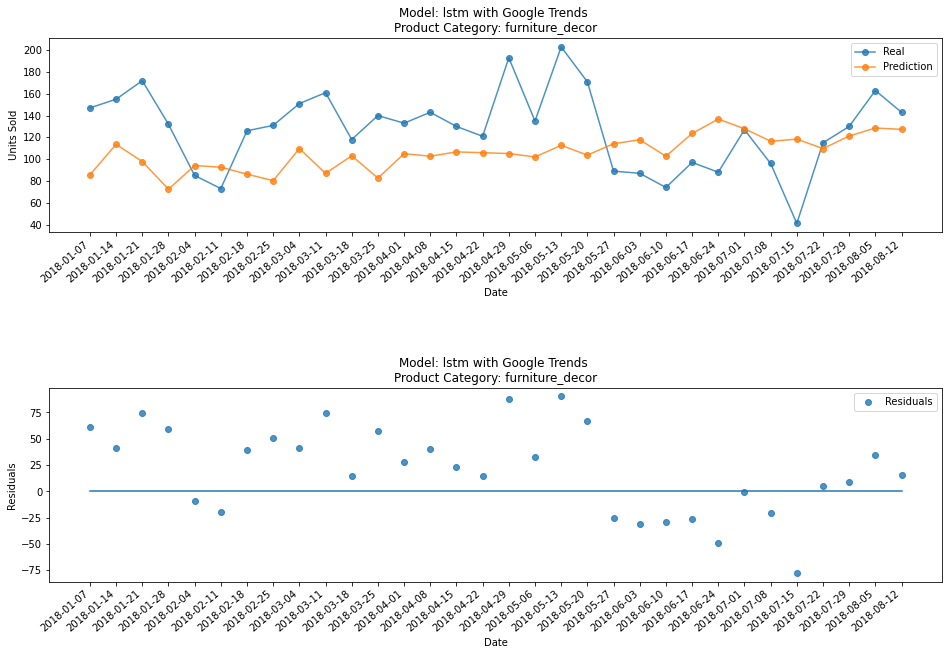

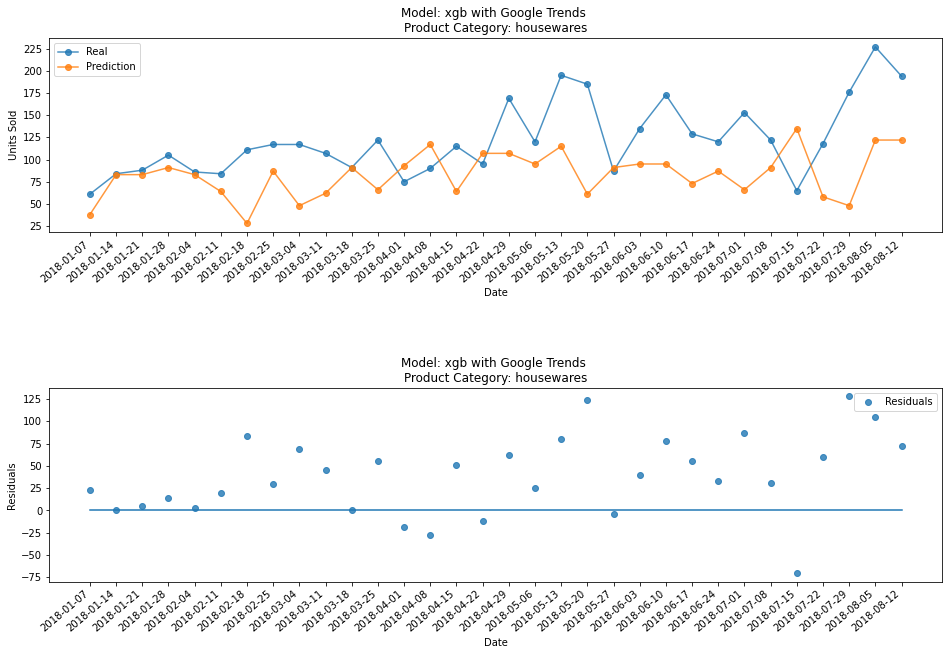

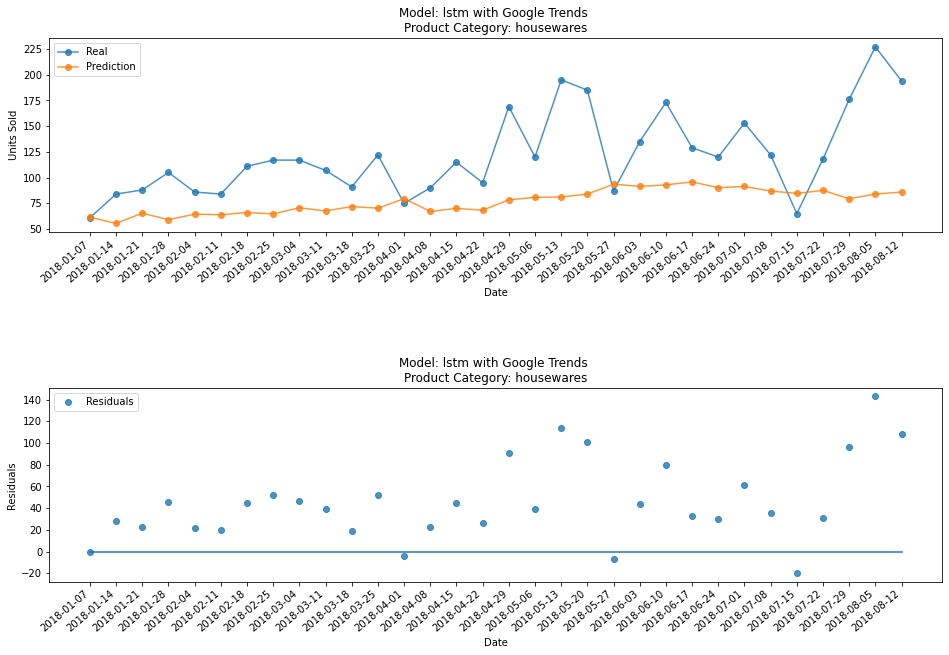

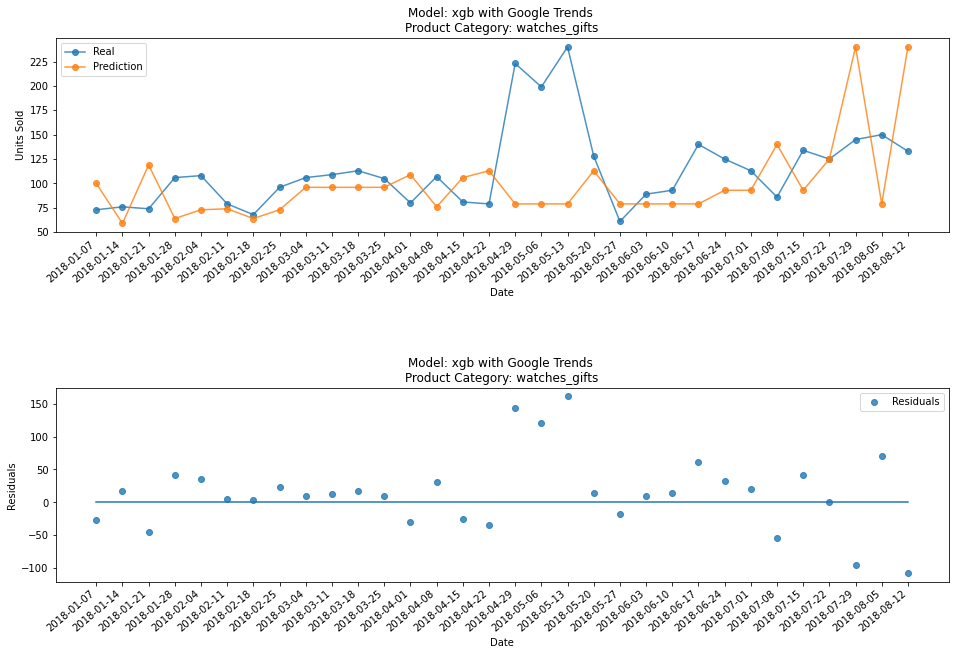

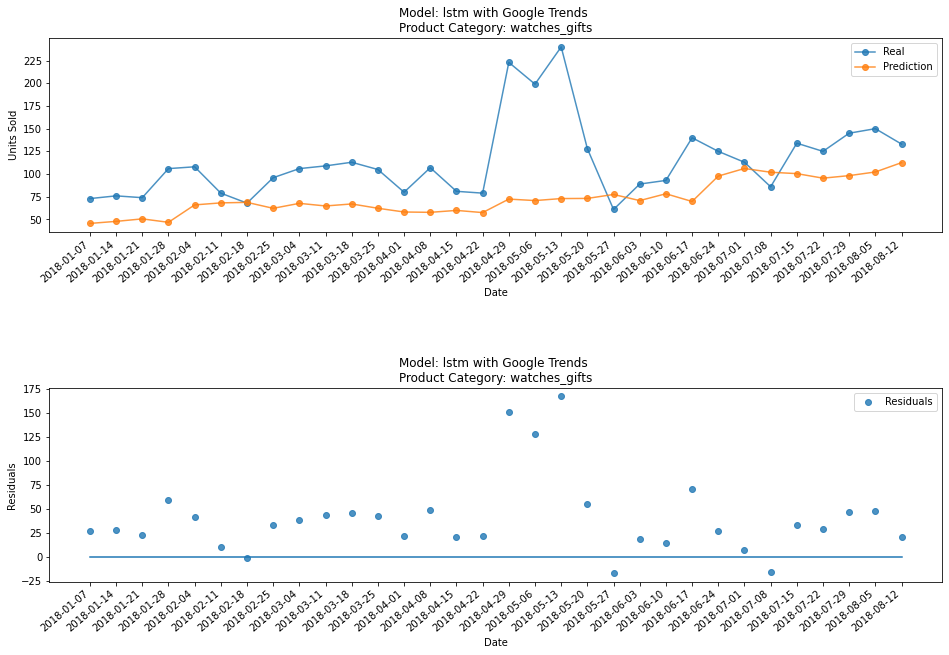

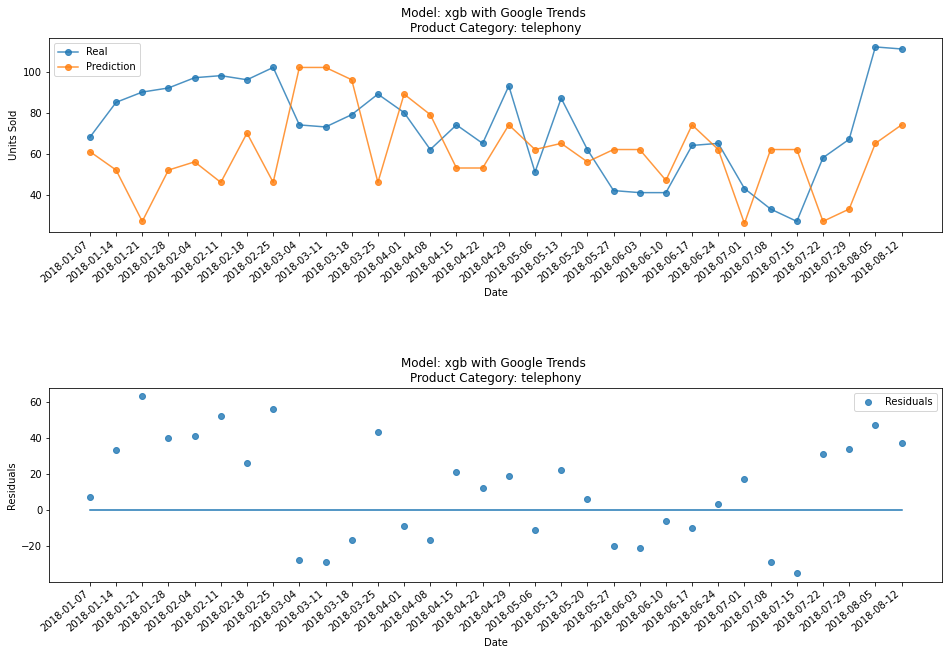

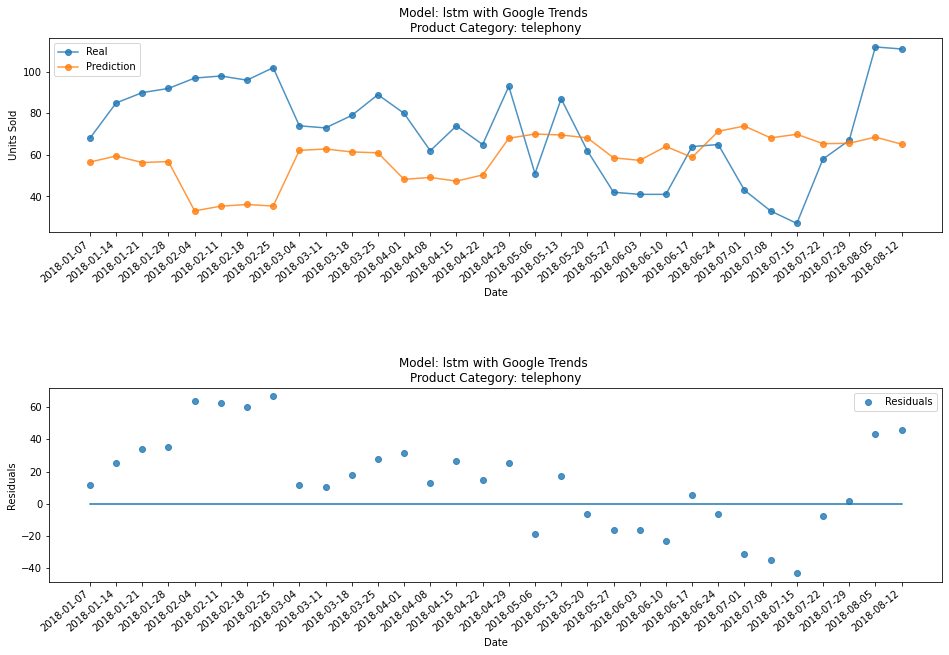

In [17]:
# Plot the forecast for each model (only with google trends)

for prod_cat in prod_categories:
    
    temp = all_product_categories[prod_cat]
    temp.sort_index(inplace=True)

    for model in ['xgb','lstm']:
        
        fig, axs = plt.subplots(2, 1, figsize=(16,10))
        plt.subplots_adjust(hspace=0.8)
        
        # Forecast
        axs[0].plot(temp['y_true'], marker='o', label='Real',alpha=0.8)
        axs[0].plot(temp[f'y_pred_{model}_gtrend'], marker='o', label='Prediction',alpha=0.8)
        axs[0].set_title(f'Model: {model} with Google Trends \nProduct Category: {prod_cat}')
        axs[0].set_xlabel('Date')
        axs[0].set_ylabel('Units Sold')
        axs[0].legend()
        for tick in axs[0].get_xticklabels():
            tick.set_rotation(40)
            tick.set_horizontalalignment('right')
            
        # Residuals
        axs[1].scatter(x=temp.index, y=(temp['y_true'] - temp[f'y_pred_{model}_gtrend']), marker='o', label='Residuals', alpha=0.8)
        axs[1].plot([0]*temp.shape[0])
        axs[1].set_title(f'Model: {model} with Google Trends \nProduct Category: {prod_cat}')
        axs[1].set_xlabel('Date')
        axs[1].set_ylabel('Residuals')
        axs[1].legend()
        for tick in axs[1].get_xticklabels():
            tick.set_rotation(40)
            tick.set_horizontalalignment('right')
            
        plt.show()
        
    print('\n\n\n')

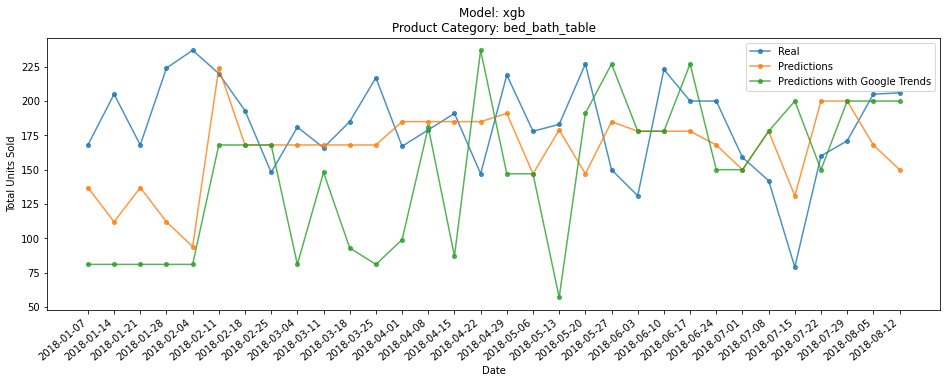

Std xgb: 27.84 and with Google Trends: 52.94


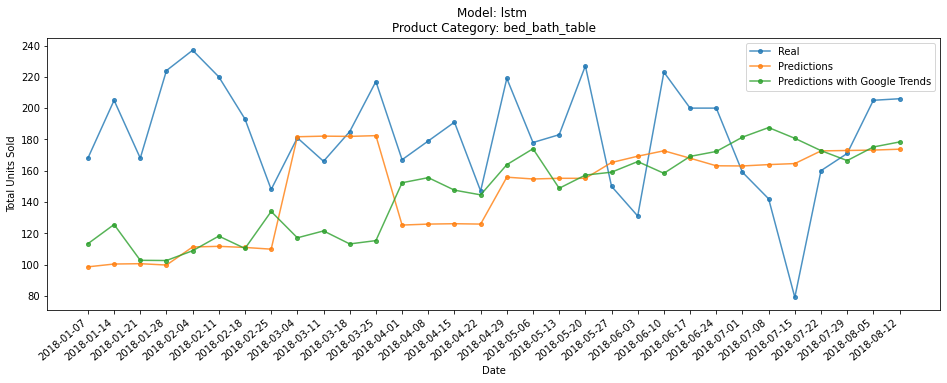

Std lstm: 29.46 and with Google Trends: 27.13






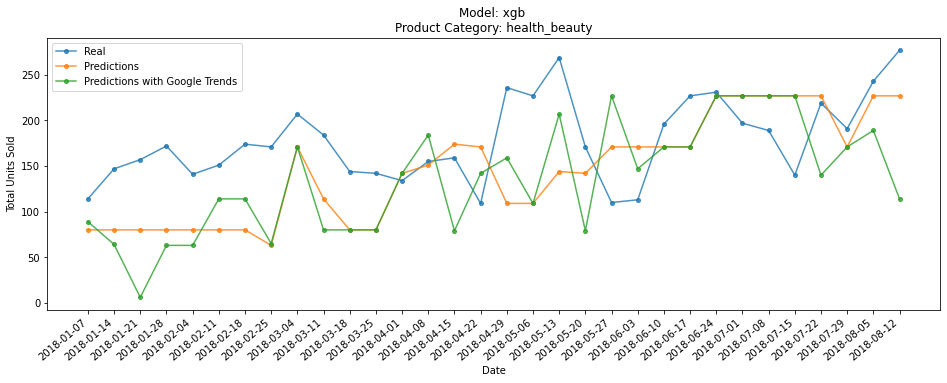

Std xgb: 57.08 and with Google Trends: 60.98


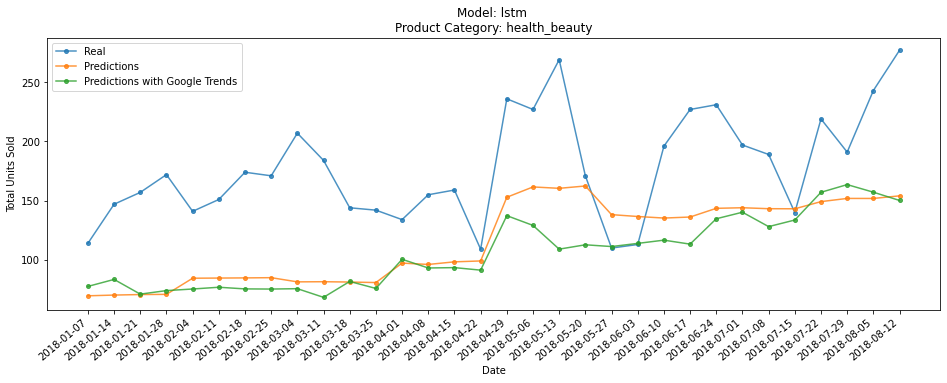

Std lstm: 33.98 and with Google Trends: 29.60






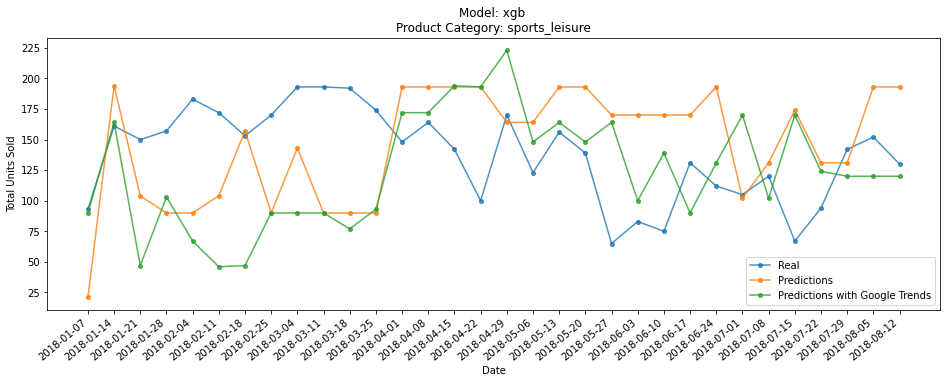

Std xgb: 46.36 and with Google Trends: 46.22


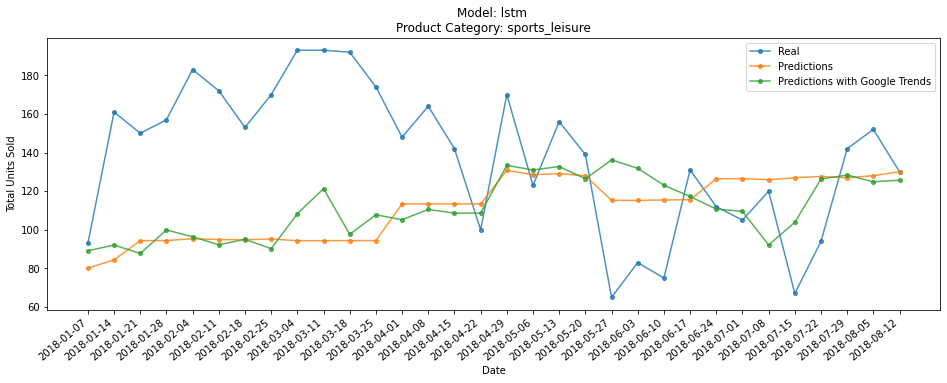

Std lstm: 15.94 and with Google Trends: 15.36






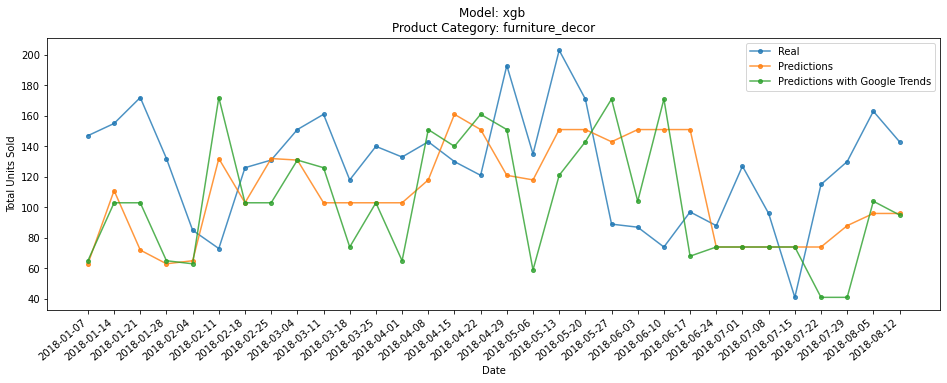

Std xgb: 31.58 and with Google Trends: 39.20


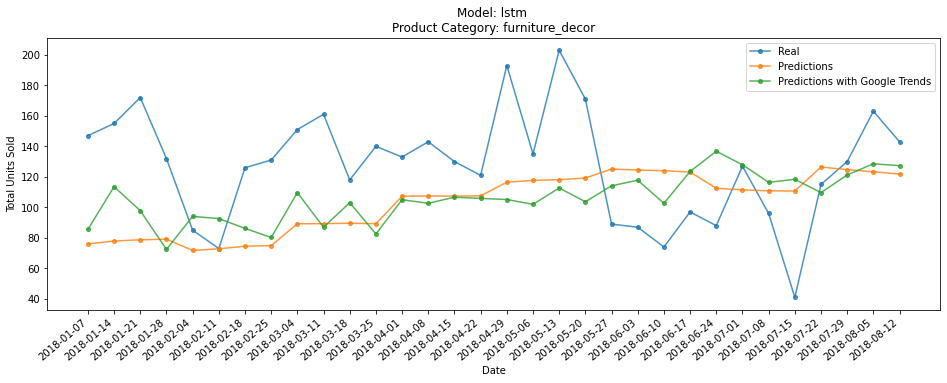

Std lstm: 19.33 and with Google Trends: 15.54






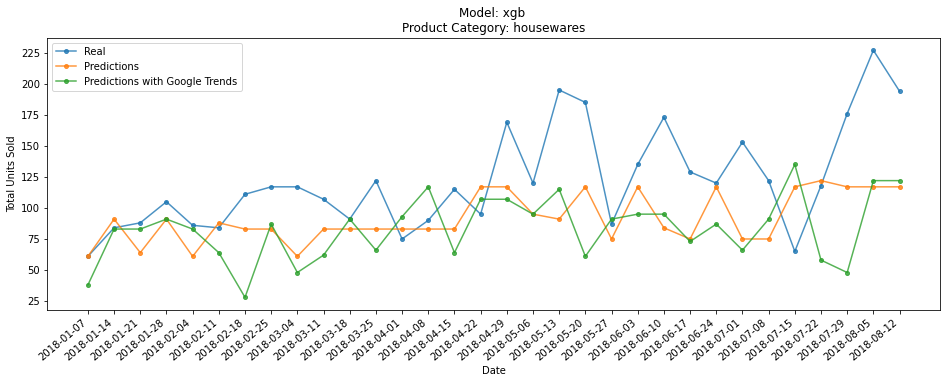

Std xgb: 19.74 and with Google Trends: 25.62


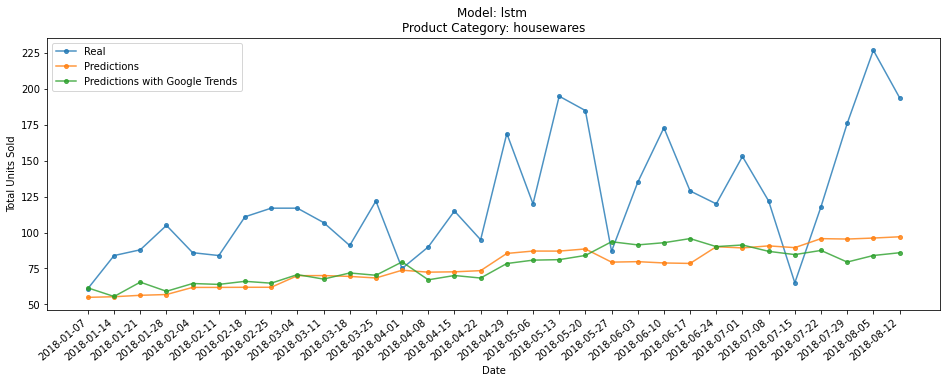

Std lstm: 13.39 and with Google Trends: 11.56






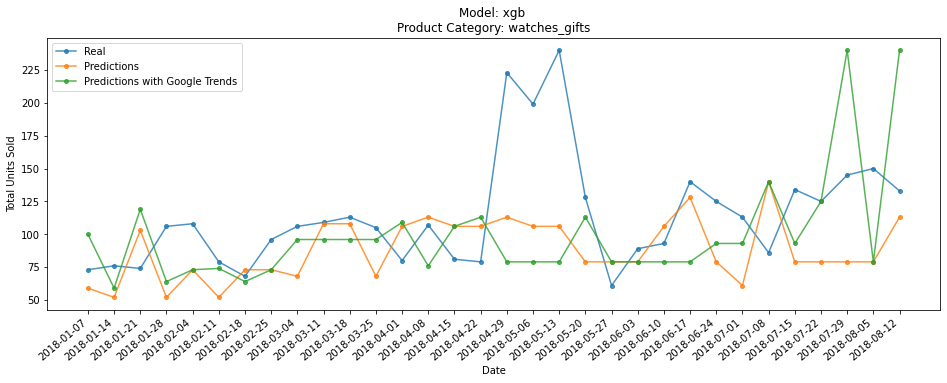

Std xgb: 23.23 and with Google Trends: 41.33


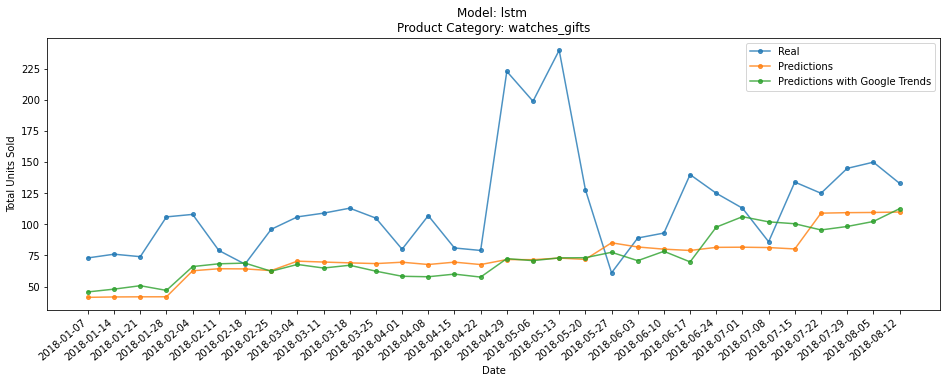

Std lstm: 18.26 and with Google Trends: 18.66






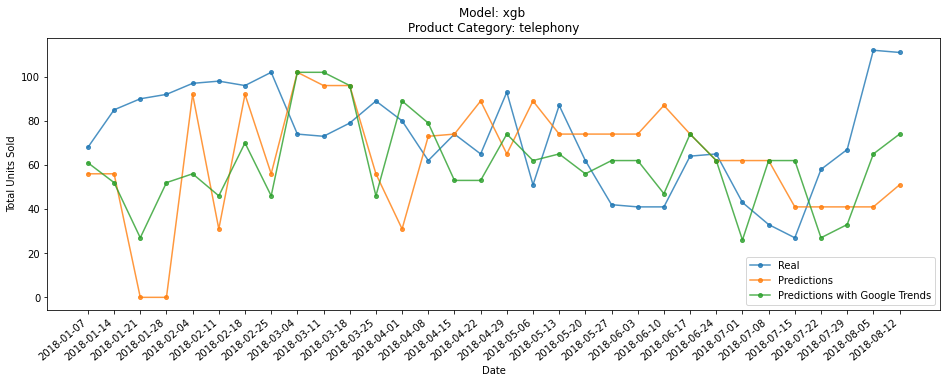

Std xgb: 25.65 and with Google Trends: 19.55


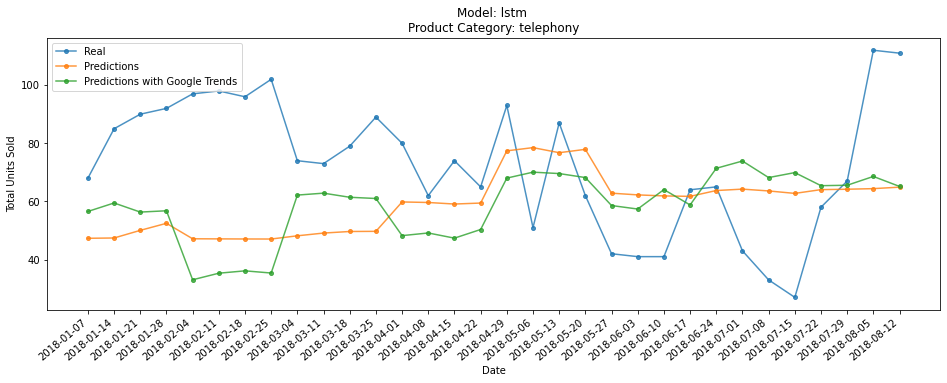

Std lstm: 9.81 and with Google Trends: 11.37






In [18]:
# Plot the forecast for each model

for prod_cat in prod_categories:
    
    temp = all_product_categories[prod_cat]
    temp.sort_index(inplace=True)

    for model in ['xgb','lstm']:
        
        fig, axs = plt.subplots(1,1, figsize=(16,5))
#         plt.figure(figsize=(16,8))
        plt.plot(temp['y_true'], marker='o', markersize=4, 
                 label='Real',alpha=0.8)
        plt.plot(temp[f'y_pred_{model}'], marker='o', markersize=4, 
                 label='Predictions',alpha=0.8)
        plt.plot(temp[f'y_pred_{model}_gtrend'], marker='o', markersize=4, 
                 label='Predictions with Google Trends',alpha=0.8)

        plt.title(f'Model: {model} \nProduct Category: {prod_cat}')
        plt.xlabel('Date')
        plt.ylabel('Total Units Sold')
        plt.legend()
        for tick in axs.get_xticklabels():
            tick.set_rotation(40)
            tick.set_horizontalalignment('right')
        plt.show()
        if model == 'xgb':
            print(f"Std xgb: {temp['y_pred_xgb'].std():.2f} and with Google Trends: {temp['y_pred_xgb_gtrend'].std():.2f}")
        if model == 'lstm':
            print(f"Std lstm: {temp['y_pred_lstm'].std():.2f} and with Google Trends: {temp['y_pred_lstm_gtrend'].std():.2f}")
        
    print('\n\n\n')
    

In [19]:
# When we add google trends, there seem to be more variation in the predictions

# Statistical Tests

- H0: XGBoost and XGBoost_GoogleTrends have the same distribution. Likewise, LSTM and LSTM_GoogleTrends have the same distribution.
- If there is no statistical difference in the average MASE/RMSSE obtained between the two experiments we reject the null hypothesis. At the α = 0.05 level, if we get a p-value less than 0.05 we reject the null hypothesis. ( since the p-value is inferior to α ).

Flach, P. A. (2017). Machine learning: the art and science of algorithms that make sense of data. Cambridge: Cambridge University Press.

In [20]:
from scipy import stats

In [21]:
# metrics_df_xgb

In [22]:
paired_results = pd.DataFrame()

xgb_gtrend_hyp = (
    metrics_df_xgb[['model','rmse','product_category']]
    .groupby(['model','product_category'])
    .mean()
    .reset_index()
    .pivot_table(index=['product_category'], columns=['model'], values='rmse')
)

paired_results['xgb'] = xgb_gtrend_hyp['xgb']
paired_results['xgb_gtrend'] = xgb_gtrend_hyp['xgb_gtrend']
paired_results['xgb - xgb_gtrend'] = paired_results['xgb'] - paired_results['xgb_gtrend']

summary_stats = pd.DataFrame()
summary_stats['std'] = paired_results.std(numeric_only=True, axis=0)
summary_stats['average'] = paired_results.mean(numeric_only=True, axis=0)


paired_results = paired_results.append(summary_stats.T)

t_test_val = pd.DataFrame({'xgb':['-'],
                       'xgb_gtrend':['-'],
                       'xgb - xgb_gtrend': [stats.ttest_rel(xgb_gtrend_hyp['xgb'], xgb_gtrend_hyp['xgb_gtrend'])[1]]})
t_test_val.index = ['p_value']

paired_results.append(t_test_val)

,xgb,xgb_gtrend,xgb - xgb_gtrend
bed_bath_table,48.5615,77.7787,-29.217238
furniture_decor,48.7542,55.2452,-6.491026
health_beauty,65.6932,77.0051,-11.311894
housewares,47.7382,58.7532,-11.014973
sports_leisure,65.592,68.6888,-3.096821
telephony,38.6761,30.4446,8.231517
watches_gifts,48.8809,58.0902,-9.209264
std,10.0002,16.2118,11.226011
average,51.9852,60.858,-8.872814
p_value,-,-,0.081469


In [23]:
# LSTM

paired_results = pd.DataFrame()

lstm_gtrend_hyp = (
    metrics_df_lstm[['model','rmse','product_category']]
    .groupby(['model','product_category'])
    .mean()
    .reset_index()
    .pivot_table(index=['product_category'], columns=['model'], values='rmse')
)

paired_results['lstm'] = lstm_gtrend_hyp['lstm']
paired_results['lstm_gtrend'] = lstm_gtrend_hyp['lstm_gtrend']
paired_results['lstm - lstm_gtrend'] = paired_results['lstm'] - paired_results['lstm_gtrend']

summary_stats = pd.DataFrame()
summary_stats['std'] = paired_results.std(numeric_only=True, axis=0)
summary_stats['average'] = paired_results.mean(numeric_only=True, axis=0)


paired_results = paired_results.append(summary_stats.T)

t_test_val = pd.DataFrame({'lstm':['-'],
                           'lstm_gtrend':['-'],
                           'lstm - lstm_gtrend': [stats.ttest_rel(lstm_gtrend_hyp['lstm'], lstm_gtrend_hyp['lstm_gtrend'])[1]]})
t_test_val.index = ['p_value']

paired_results.append(t_test_val)

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,lstm,lstm_gtrend,lstm - lstm_gtrend
bed_bath_table,58.4684,60.5893,-2.120873
furniture_decor,47.9022,46.0947,1.807512
health_beauty,72.8136,81.2263,-8.412787
housewares,56.9316,58.6455,-1.713985
sports_leisure,52.9695,50.9816,1.987882
telephony,30.4054,32.2064,-1.800997
watches_gifts,56.726,56.8341,-0.108090
std,12.8091,15.002,3.496382
average,53.7452,55.2254,-1.480191
p_value,-,-,0.305503


### MASE T-Test (XGBoost)

In [24]:
paired_results = pd.DataFrame()

xgb_gtrend_hyp = (
    metrics_df_xgb[['model','mase','product_category']]
    .groupby(['model','product_category'])
    .mean()
    .reset_index()
    .pivot_table(index=['product_category'], columns=['model'], values='mase')
)

paired_results['xgb'] = xgb_gtrend_hyp['xgb']
paired_results['xgb_gtrend'] = xgb_gtrend_hyp['xgb_gtrend']
paired_results['xgb - xgb_gtrend'] = paired_results['xgb'] - paired_results['xgb_gtrend']

summary_stats = pd.DataFrame()
summary_stats['std'] = paired_results.std(numeric_only=True, axis=0)
summary_stats['average'] = paired_results.mean(numeric_only=True, axis=0)


paired_results = paired_results.append(summary_stats.T)

t_test_val = pd.DataFrame({'xgb':['-'],
                       'xgb_gtrend':['-'],
                       'xgb - xgb_gtrend': [stats.ttest_rel(xgb_gtrend_hyp['xgb'], xgb_gtrend_hyp['xgb_gtrend'])[1]]})
t_test_val.index = ['p_value']

paired_results.append(t_test_val)

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,xgb,xgb_gtrend,xgb - xgb_gtrend
bed_bath_table,1.08877,1.85667,-0.767898
furniture_decor,1.62227,1.82756,-0.205291
health_beauty,2.32528,2.77541,-0.450138
housewares,1.7564,2.24297,-0.486571
sports_leisure,2.6996,2.62175,0.077845
telephony,2.39207,2.05313,0.338937
watches_gifts,2.23798,2.42798,-0.190000
std,0.553145,0.369114,0.370479
average,2.01748,2.25793,-0.240445
p_value,-,-,0.136767


### MASE T-Test (LSTM)

In [25]:
paired_results = pd.DataFrame()

lstm_gtrend_hyp = (
    metrics_df_lstm[['model','mase','product_category']]
    .groupby(['model','product_category'])
    .mean()
    .reset_index()
    .pivot_table(index=['product_category'], columns=['model'], values='mase')
)

paired_results['lstm'] = lstm_gtrend_hyp['lstm']
paired_results['lstm_gtrend'] = lstm_gtrend_hyp['lstm_gtrend'] # [100] * 12#
paired_results['lstm - lstm_gtrend'] = paired_results['lstm'] - paired_results['lstm_gtrend']

summary_stats = pd.DataFrame()
summary_stats['std'] = paired_results.std(numeric_only=True, axis=0)
summary_stats['average'] = paired_results.mean(numeric_only=True, axis=0)


paired_results = paired_results.append(summary_stats.T)

t_test_val = pd.DataFrame({'lstm':['-'],
                           'lstm_gtrend':['-'],
#                            'lstm - lstm_gtrend': [stats.ttest_rel(lstm_gtrend_hyp['lstm'], [100] * 12)[1]]})
                           'lstm - lstm_gtrend': [stats.ttest_rel(lstm_gtrend_hyp['lstm'], lstm_gtrend_hyp['lstm_gtrend'])[1]]})
t_test_val.index = ['p_value']

paired_results.append(t_test_val)

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,lstm,lstm_gtrend,lstm - lstm_gtrend
bed_bath_table,1.37577,1.45242,-0.076648
furniture_decor,1.54261,1.47685,0.065762
health_beauty,2.75521,3.01405,-0.258832
housewares,2.24742,2.26066,-0.013235
sports_leisure,2.05983,2.00014,0.059687
telephony,2.02301,2.08474,-0.061727
watches_gifts,2.45436,2.48015,-0.025785
std,0.484938,0.551211,0.109246
average,2.06546,2.10986,-0.044397
p_value,-,-,0.323605


### RMSSE T-Test (XGBoost)

In [26]:
paired_results = pd.DataFrame()

xgb_gtrend_hyp = (
    metrics_df_xgb[['model','rmsse','product_category']]
    .groupby(['model','product_category'])
    .mean()
    .reset_index()
    .pivot_table(index=['product_category'], columns=['model'], values='rmsse')
)

paired_results['xgb'] = xgb_gtrend_hyp['xgb']
paired_results['xgb_gtrend'] = xgb_gtrend_hyp['xgb_gtrend']
paired_results['xgb - xgb_gtrend'] = paired_results['xgb'] - paired_results['xgb_gtrend']

summary_stats = pd.DataFrame()
summary_stats['std'] = paired_results.std(numeric_only=True, axis=0)
summary_stats['average'] = paired_results.mean(numeric_only=True, axis=0)


paired_results = paired_results.append(summary_stats.T)

t_test_val = pd.DataFrame({'xgb':['-'],
                       'xgb_gtrend':['-'],
                       'xgb - xgb_gtrend': [stats.ttest_rel(xgb_gtrend_hyp['xgb'], xgb_gtrend_hyp['xgb_gtrend'])[1]]})
t_test_val.index = ['p_value']

paired_results.append(t_test_val)

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,xgb,xgb_gtrend,xgb - xgb_gtrend
bed_bath_table,0.936339,1.49969,-0.563352
furniture_decor,1.21331,1.37485,-0.161538
health_beauty,1.78705,2.09476,-0.307716
housewares,1.65084,2.03175,-0.380910
sports_leisure,2.23337,2.33882,-0.105445
telephony,2.0848,1.64109,0.443712
watches_gifts,1.69873,2.01877,-0.320044
std,0.456457,0.354058,0.320299
average,1.65778,1.8571,-0.199328
p_value,-,-,0.150761


### RMSSE T-Test (LSTM)

In [27]:
paired_results = pd.DataFrame()

lstm_gtrend_hyp = (
    metrics_df_lstm[['model','rmsse','product_category']]
    .groupby(['model','product_category'])
    .mean()
    .reset_index()
    .pivot_table(index=['product_category'], columns=['model'], values='rmsse')
)

paired_results['lstm'] = lstm_gtrend_hyp['lstm']
paired_results['lstm_gtrend'] = lstm_gtrend_hyp['lstm_gtrend'] # [100] * 12#
paired_results['lstm - lstm_gtrend'] = paired_results['lstm'] - paired_results['lstm_gtrend']

summary_stats = pd.DataFrame()
summary_stats['std'] = paired_results.std(numeric_only=True, axis=0)
summary_stats['average'] = paired_results.mean(numeric_only=True, axis=0)


paired_results = paired_results.append(summary_stats.T)

t_test_val = pd.DataFrame({'lstm':['-'],
                           'lstm_gtrend':['-'],
#                            'lstm - lstm_gtrend': [stats.ttest_rel(lstm_gtrend_hyp['lstm'], [100] * 12)[1]]})
                           'lstm - lstm_gtrend': [stats.ttest_rel(lstm_gtrend_hyp['lstm'], lstm_gtrend_hyp['lstm_gtrend'])[1]]})
t_test_val.index = ['p_value']

paired_results.append(t_test_val)

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,lstm,lstm_gtrend,lstm - lstm_gtrend
bed_bath_table,1.12736,1.16825,-0.040894
furniture_decor,1.19211,1.14713,0.044982
health_beauty,1.98074,2.20959,-0.228852
housewares,1.96876,2.02803,-0.059271
sports_leisure,1.80358,1.7359,0.067686
telephony,1.63897,1.73605,-0.097081
watches_gifts,1.97136,1.97512,-0.003756
std,0.369294,0.41484,0.099356
average,1.66898,1.7143,-0.045312
p_value,-,-,0.272990
